# F25: Forecasting Daily Energy Production Using Weather Data

##**Data sources and descriptions:**
* energy (`yearly xlsx files`): https://www.iso-ne.com/isoexpress/web/reports/operations/-/tree/daily-gen-fuel-type
* weather (`daily.txt`): https://mesonet.agron.iastate.edu/request/daily.phtml?network=CT_ASOS


In this project, we built a data-driven forecasting system to predict daily energy production using historical generation data and daily weather conditions. The goal was to forecast all days in 2025 using only information available before January 1, 2025, closely mirroring a real-world forecasting setup used by energy operators.

##**Data Preparation and Feature Engineering**

We split the data strictly by time to avoid leakage:

* **Training set:** all days before 2025
* **Test set:** all days in 2025

To capture temporal structure and real-world behavior, we engineered several features:

* Lagged energy and weather variables (previous-day effects)

* Rolling statistics (moving averages and trends)

* Time-based features such as day of week, month, and seasonal indicators

Missing values were handled using explicit imputation strategies, with clear justification based on the business meaning of the variables.

##**Exploratory Data Analysis**

We performed detailed EDA using:

* Time-series plots to understand long-term trends

* Weather–energy relationship plots to identify key drivers

* Lag and rolling feature visualizations to justify model inputs

* Summary tables highlighting seasonal and fuel-type patterns

All plots and tables were designed to support modeling decisions and explain how weather influences energy production.

##**Modeling Approach**

We trained deep learning forecasting models consistent with the course requirements, including:

* Feedforward Deep Neural Networks (DNN)

* Sequence models such as GRU and LSTM

Models were trained only on pre-2025 data. Architecture choices, input lags, and hyperparameters were selected based on empirical performance and domain intuition.

##**Model Evaluation**

Model performance was evaluated on both training and test sets using:

* Mean Absolute Error (MAE)

* Root Mean Squared Error (RMSE)

* Mean Absolute Percentage Error (MAPE)

We validated results using:

* Time-series plots of actual vs. predicted values

* Scatter plots with a 45° reference line to assess bias and dispersion

Special care was taken to ensure date alignment and consistent evaluation windows.

##**Interpretability and Insights**

To understand why the model performs as it does, we analyzed:

* Feature and lag importance

* Temporal patterns where the model under- or over-predicts

* Weather conditions associated with unusually high or low energy production

We translated these findings into **business-relevant insights**, such as how extreme temperatures or weather shifts impact different fuel types and how operators could plan more effectively.

##**Key Takeaways**

This project demonstrates an end-to-end forecasting workflow:

* Working with messy, real-world data

* Designing time-aware features

* Training and evaluating deep learning models

* Interpreting results in a business context

The final notebook is structured to function as both **technical documentation** and a **stakeholder-facing forecasting report.**

# 1. EDA, Data Cleaning, and Feature Engineering

### Connect Colab to drive
Here I am just connecting my Google Drive to Colab.  
This lets me open my files from Drive inside the notebook.  
If the drive is already mounted, Colab will show a message saying it is already connected.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Read and join the Excel files

Here I am loading all my Excel files from the folder.  
I go through the directory, pick all the `.xlsx` files, and read the sheet named DAYGENBYFUEL from each file.  
I put all the DataFrames into a list and then join them into one big DataFrame.  
After joining, I change the DATE column to datetime and set it as the index.  
This gives me one clean dataset with all the years combined.







In [2]:
import pandas as pd
import os

# Define the directory containing the Excel files
directory_path = '/content/drive/MyDrive/Sem3/DL/final proj/FinalProjects_F25'

# Get a list of all files in the directory and its subdirectories
excel_files = []
for root, _, files in os.walk(directory_path):
    for f in files:
        if f.endswith('.xlsx'):
            excel_files.append(os.path.join(root, f))

# Initialize an empty list to store DataFrames
df_list = []

# Read each Excel file and append the 'DAYGENBYFUEL' sheet to the list
for excel_file in excel_files:
    try:
        df = pd.read_excel(excel_file, sheet_name='DAYGENBYFUEL')
        df_list.append(df)
    except Exception as e:
        print(f"Error reading {excel_file}: {e}")

# Concatenate all DataFrames in the list
if df_list:
    energy_df = pd.concat(df_list, ignore_index=True)
    # Convert 'DATE' to datetime and set it as index
    energy_df['DATE'] = pd.to_datetime(energy_df['DATE'])
    energy_df.set_index('DATE', inplace=True)
    print("Successfully combined energy data:")
    display(energy_df.head())
else:
    print("No Excel files found or no data read.")

Successfully combined energy data:


,COAL,GAS,HYDRO,NUCLEAR,OIL,LANDFILL GAS,METHANE,REFUSE,SOLAR,STEAM,WIND,WOOD,OTHER,PRD,TOTAL
DATE,,,,,,,,,,,,,,,
2024-01-01,0.52,143001.686,32421.494,80679.820,4.003,1324.555,102.454,7534.500,6094.881,0,1598.842,4647.784,564.650,-0.098203,277975.090797
2024-01-02,17.12,151184.104,33293.692,80709.102,0.338,1310.940,92.596,7325.074,9487.691,0,4717.724,4660.427,828.647,-0.547897,293626.907103
2024-01-03,42.36,165047.508,30801.607,80728.718,104.270,1286.653,98.708,7360.587,6078.123,0,2370.850,5011.797,586.583,-0.019693,299517.744307
2024-01-04,118.84,141876.957,28588.978,80728.952,0.000,1272.456,109.081,7424.549,4976.516,0,8239.160,6218.011,468.836,0.000000,280022.336000
2024-01-05,17.17,145419.336,29596.409,80707.418,136.345,1275.857,107.875,7980.069,9549.611,0,13255.615,6745.573,712.909,0.000000,295504.187000


### Max Energy

Here I am just checking the latest date available in my combined dataset.  
I use the index of the DataFrame because the index is already set to the DATE column.  
This helps me confirm the most recent day in the data.


### Missing Data Handling
The `combined_df_sorted` DataFrame, after joining energy and weather data, has a total of 2126 entries. Most columns are complete, but a few have missing values:

*   **`max_wind_gust_kts`**: Has 5 missing values (2121 non-null out of 2126).
*   **`srad_mj`**: Has all 2126 values missing, indicating it's completely empty.

Since `srad_mj` is entirely null, it has been dropped as a feature. For the `max_wind_gust_kts` column, given the small number of missing values and the nature of the data, **zero imputation** is used. This strategy assumes that a missing wind gust measurement implies no significant gust occurred or it was negligible. This approach is simple and effective for a small proportion of missing data, preventing data loss while maintaining the integrity of the remaining features.

In [3]:
print(energy_df.index.max())

2025-10-26 00:00:00


### Information

Here I am checking the basic info of the DataFrame.  
This shows me how many rows I have, the date range, and all the column names.  
It also tells me if there are any missing values and what data types each column has.  
This helps me confirm that all files were joined correctly and the data looks clean.


In [4]:
energy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2126 entries, 2024-01-01 to 2025-10-26
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   COAL          2126 non-null   float64
 1   GAS           2126 non-null   float64
 2   HYDRO         2126 non-null   float64
 3   NUCLEAR       2126 non-null   float64
 4   OIL           2126 non-null   float64
 5   LANDFILL GAS  2126 non-null   float64
 6   METHANE       2126 non-null   float64
 7   REFUSE        2126 non-null   float64
 8   SOLAR         2126 non-null   float64
 9   STEAM         2126 non-null   int64  
 10  WIND          2126 non-null   float64
 11  WOOD          2126 non-null   float64
 12  OTHER         2126 non-null   float64
 13  PRD           2126 non-null   float64
 14  TOTAL         2126 non-null   float64
dtypes: float64(14), int64(1)
memory usage: 265.8 KB


I found that the dataset has 2126 days of data, from 2024-01-01 to 2025-10-26.  
All 15 columns have no missing values, and most of them are stored as float64.


### Setting the datetime as the index allows for easy joining.
###Plotting energy generation over time

Here I am plotting all the fuel types (except TOTAL) to see how their generation changes over time.  
This helps me understand which fuels are used the most and how their patterns move across the months.  
From the plot, I can see that GAS is the highest and shows strong seasonal changes, while other fuels stay much lower.


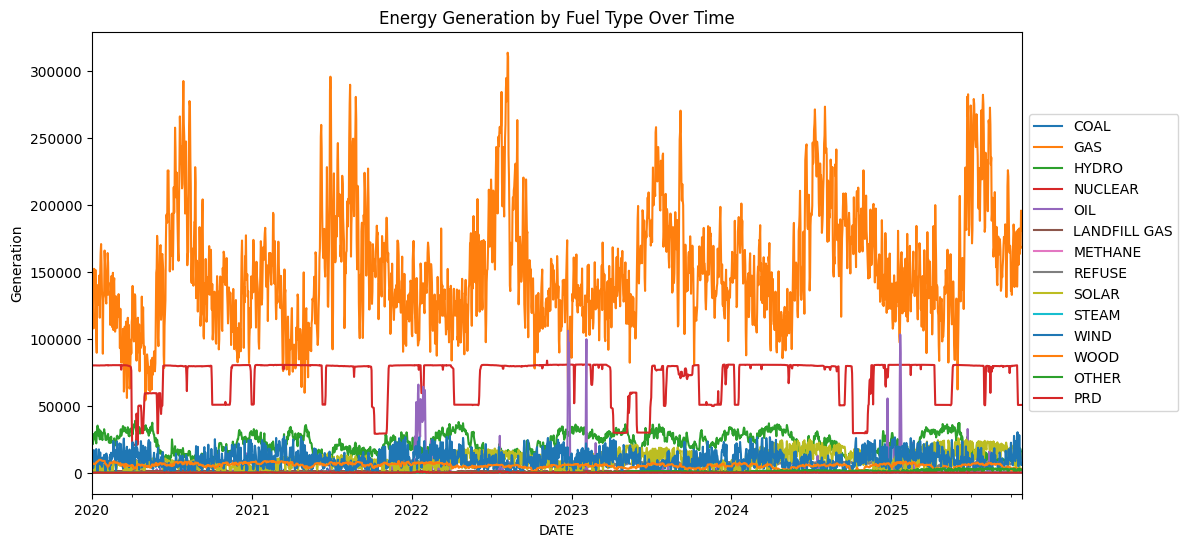

In [5]:
import matplotlib.pyplot as plt

# Sort the DataFrame by index (DATE)
energy_df_sorted = energy_df.sort_index()

# Plot all columns except 'TOTAL'
ax = energy_df_sorted.drop('TOTAL', axis=1).plot(figsize=(12, 6))

# Put legend on the left
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title('Energy Generation by Fuel Type Over Time')
plt.xlabel('DATE')
plt.ylabel('Generation')
plt.show()

### Concatenate the weather data

Here I am loading the daily weather file from my Drive.  
I convert the day column into a datetime index so it lines up with my energy data.  
After that, I check the first few rows to make sure the weather data loaded correctly.


In [6]:
weather_df = pd.read_csv('/content/drive/MyDrive/Sem3/DL/final proj/FinalProjects_F25/Daily_GenerationByFuel/daily.txt')
print(weather_df.columns)
weather_df['day'] = pd.to_datetime(weather_df['day'])
weather_df.set_index('day', inplace=True)
weather_df.index.name = 'DATE' # Rename the index to match energy_df
print("Successfully loaded weather data:")
display(weather_df.head())

Index(['station', 'day', 'max_temp_f', 'min_temp_f', 'max_dewpoint_f',
       'min_dewpoint_f', 'precip_in', 'avg_wind_speed_kts', 'avg_wind_drct',
       'min_rh', 'avg_rh', 'min_feel', 'avg_feel', 'max_feel',
       'max_wind_speed_kts', 'max_wind_gust_kts', 'srad_mj'],
      dtype='object')
Successfully loaded weather data:


,station,max_temp_f,min_temp_f,max_dewpoint_f,min_dewpoint_f,precip_in,avg_wind_speed_kts,avg_wind_drct,min_rh,avg_rh,min_feel,avg_feel,max_feel,max_wind_speed_kts,max_wind_gust_kts,srad_mj
DATE,,,,,,,,,,,,,,,,
2020-01-01,BDL,39.0,32.0,30.0,21.9,0.0000,7.733889,266.43234,54.005466,65.49050,24.881613,28.401140,30.974932,18.248500,22.593382,NaN
2020-01-02,BDL,47.0,29.0,30.9,21.0,0.0000,7.125605,202.84612,45.473473,61.92596,22.713701,31.288322,40.921917,13.034643,17.379524,NaN
2020-01-03,BDL,47.0,37.0,39.9,32.0,0.0000,3.736598,180.81580,63.327920,76.16676,31.380903,40.076496,46.900000,10.427715,11.296691,NaN
2020-01-04,BDL,41.0,38.0,39.9,34.0,0.2200,3.910393,349.59344,85.689926,94.66637,29.922384,36.497646,39.900000,12.165668,16.510550,NaN
2020-01-05,BDL,39.0,25.0,33.1,17.1,0.0001,11.731179,314.79974,45.733845,61.13799,21.581379,25.550707,32.636097,25.200312,34.759050,NaN


### Weather Data Quality

Here I am checking the structure of the weather DataFrame.  
This helps me see how many rows I have, how clean the data is, and whether any columns have missing values.

I found that the dataset has 2134 days of weather data from 2020 to 2025.  
A few columns have small amounts of missing values, especially in wind and precipitation.


In [7]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2134 entries, 2020-01-01 to 2025-11-03
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station             2134 non-null   object 
 1   max_temp_f          2132 non-null   float64
 2   min_temp_f          2132 non-null   float64
 3   max_dewpoint_f      2134 non-null   float64
 4   min_dewpoint_f      2134 non-null   float64
 5   precip_in           2131 non-null   float64
 6   avg_wind_speed_kts  2133 non-null   float64
 7   avg_wind_drct       2133 non-null   float64
 8   min_rh              2134 non-null   float64
 9   avg_rh              2133 non-null   float64
 10  min_feel            2134 non-null   float64
 11  avg_feel            2133 non-null   float64
 12  max_feel            2134 non-null   float64
 13  max_wind_speed_kts  2134 non-null   float64
 14  max_wind_gust_kts   2128 non-null   float64
 15  srad_mj             0 non-null      f

### Join Datasets (2126 rows)

Here I am joining the energy data and the weather data using the DATE index.  
I sort the combined DataFrame and then split the columns into energy variables and weather variables.  
After that, I plot them to see how both sets of features behave over time.

I can see that the join worked correctly because the combined dataset has 2126 rows, matching the energy data range.  
The plots show clear seasonal patterns in both energy usage and weather conditions.


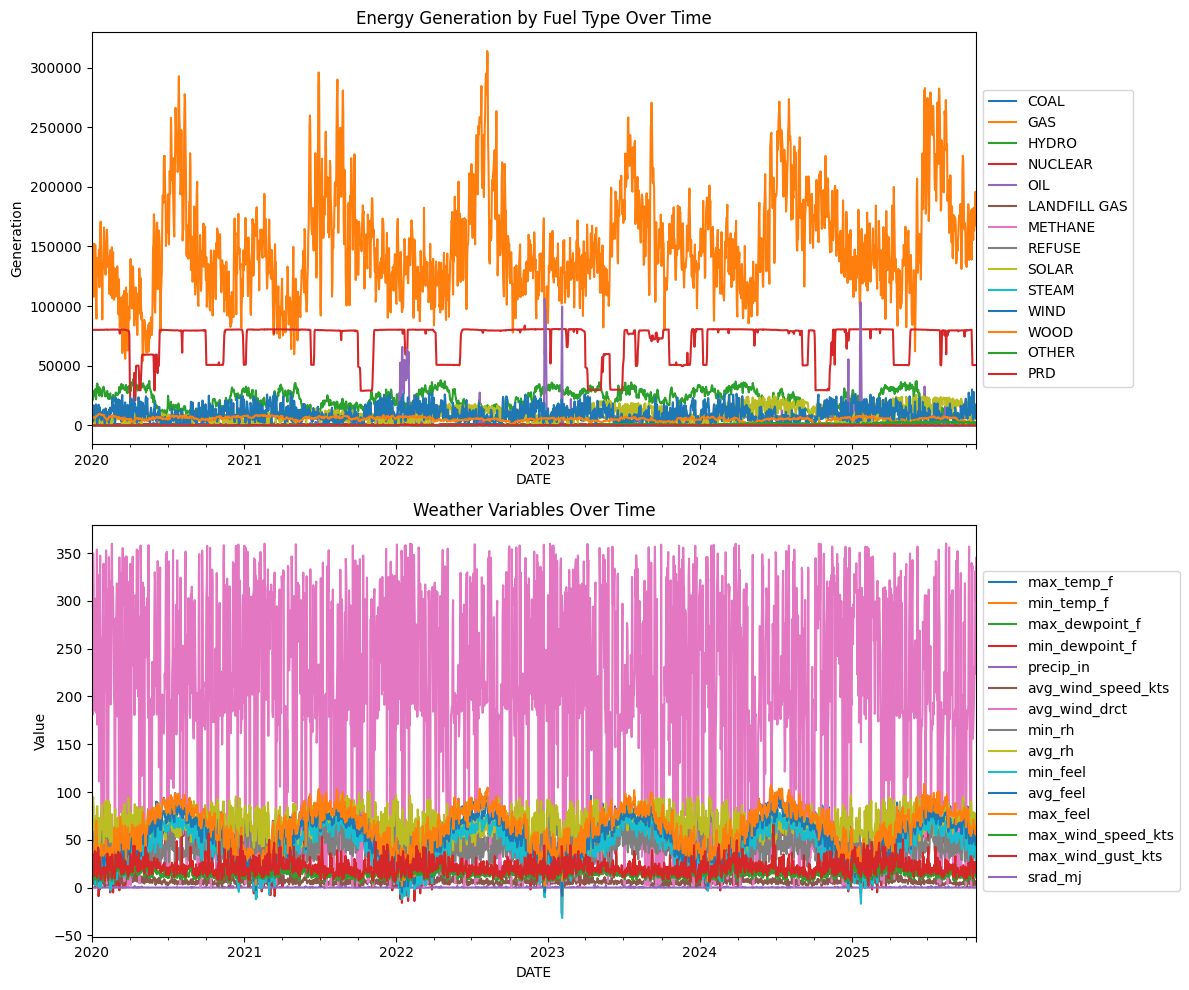

,COAL,GAS,HYDRO,NUCLEAR,OIL,LANDFILL GAS,METHANE,REFUSE,SOLAR,STEAM,...,avg_wind_speed_kts,avg_wind_drct,min_rh,avg_rh,min_feel,avg_feel,max_feel,max_wind_speed_kts,max_wind_gust_kts,srad_mj
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-01,95.90,102970.510,24703.740,80033.620,3.032,1403.857,115.840,8895.274,2786.022,0,...,7.733889,266.43234,54.005466,65.49050,24.881613,28.401140,30.974932,18.248500,22.593382,NaN
2020-01-02,23.64,122207.567,26767.720,80108.307,2885.127,1310.237,111.015,8177.457,3216.760,0,...,7.125605,202.84612,45.473473,61.92596,22.713701,31.288322,40.921917,13.034643,17.379524,NaN
2020-01-03,7.92,130630.104,21279.433,80151.023,3728.965,1303.274,104.657,7197.085,805.358,0,...,3.736598,180.81580,63.327920,76.16676,31.380903,40.076496,46.900000,10.427715,11.296691,NaN
2020-01-04,4.65,116483.404,24130.018,80154.281,0.000,1393.793,108.827,8359.937,338.083,0,...,3.910393,349.59344,85.689926,94.66637,29.922384,36.497646,39.900000,12.165668,16.510550,NaN
2020-01-05,50.63,107861.645,24674.196,80141.079,221.507,1356.650,108.903,8574.118,2581.808,0,...,11.731179,314.79974,45.733845,61.13799,21.581379,25.550707,32.636097,25.200312,34.759050,NaN


In [8]:
# Join the two dataframes on their index (DATE)
combined_df = energy_df.join(weather_df, how='inner')

# Sort the combined dataframe by date
combined_df_sorted = combined_df.sort_index()

# Separate weather and energy columns (excluding 'TOTAL' and 'station')
energy_columns = energy_df.columns.drop('TOTAL')
weather_columns = weather_df.columns.drop('station') # Assuming 'station' is not needed for plotting

# Create a two-panel plot
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

# Plot energy variables
combined_df_sorted[energy_columns].plot(ax=axes[0])
axes[0].set_title('Energy Generation by Fuel Type Over Time')
axes[0].set_ylabel('Generation')
axes[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Plot weather variables
combined_df_sorted[weather_columns].plot(ax=axes[1])
axes[1].set_title('Weather Variables Over Time')
axes[1].set_xlabel('DATE')
axes[1].set_ylabel('Value')
axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

display(combined_df_sorted.head())

You can see the data quality is VERY good. Just use zero imputation for missing values!

In [9]:
combined_df_sorted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2126 entries, 2020-01-01 to 2025-10-26
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   COAL                2126 non-null   float64
 1   GAS                 2126 non-null   float64
 2   HYDRO               2126 non-null   float64
 3   NUCLEAR             2126 non-null   float64
 4   OIL                 2126 non-null   float64
 5   LANDFILL GAS        2126 non-null   float64
 6   METHANE             2126 non-null   float64
 7   REFUSE              2126 non-null   float64
 8   SOLAR               2126 non-null   float64
 9   STEAM               2126 non-null   int64  
 10  WIND                2126 non-null   float64
 11  WOOD                2126 non-null   float64
 12  OTHER               2126 non-null   float64
 13  PRD                 2126 non-null   float64
 14  TOTAL               2126 non-null   float64
 15  station             2126 non-null   o

Here I am checking the full combined DataFrame to see if the join created any issues.  
The output shows that almost all columns have complete data for all 2126 rows.

Only two columns have a few missing values (max_wind_gust_kts and srad_mj).  
This means the combined dataset is very clean, and simple zero imputation will be enough.







### Holdout Dataset: 2025 data

Here I split the combined dataset into training data (all years before 2025) and testing data (all of 2025).  
This gives me 1827 rows for training and 299 rows for testing.

I save both DataFrames as CSV files so I can use them later when I build my models.


In [10]:
train_df = combined_df_sorted[combined_df_sorted.index.year < 2025]
test_df = combined_df_sorted[combined_df_sorted.index.year >= 2025]

print("Shape of training data:", train_df.shape)
print("Shape of testing data:", test_df.shape)

Shape of training data: (1827, 31)
Shape of testing data: (299, 31)


In [11]:
train_df.to_csv(directory_path + '/train_df.csv')
test_df.to_csv(directory_path + '/test_df.csv')

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error

traindf = pd.read_csv('/content/drive/MyDrive/Sem3/DL/final proj/FinalProjects_F25/train_df.csv', index_col='DATE', parse_dates=True)
testdf = pd.read_csv('/content/drive/MyDrive/Sem3/DL/final proj/FinalProjects_F25/test_df.csv', index_col='DATE', parse_dates=True)

## checking data leakage
We are predicting 'TOTAL' - the sum of all generation by type for the day.

If we are trying to predict today's total generation - we can't use the individual values of coal, gas, hydro etc.

In [13]:
# Column names
production_columns = ['COAL', 'GAS', 'HYDRO', 'NUCLEAR', 'OIL', 'LANDFILL GAS', 'METHANE', 'REFUSE', 'SOLAR', 'STEAM', 'WIND', 'WOOD', 'OTHER', 'PRD']

# Check for train_df
traindf['Calculated_TOTAL'] = traindf[production_columns].sum(axis=1)
print("Train Data - Are 'TOTAL' and 'Calculated_TOTAL' equal?")
display(traindf[['TOTAL', 'Calculated_TOTAL']].head())


# Check for test_df
testdf['Calculated_TOTAL'] = testdf[production_columns].sum(axis=1)
print("\nTest Data - Are 'TOTAL' and 'Calculated_TOTAL' equal?")
display(testdf[['TOTAL', 'Calculated_TOTAL']].head())


Train Data - Are 'TOTAL' and 'Calculated_TOTAL' equal?


,TOTAL,Calculated_TOTAL
DATE,,
2020-01-01,239647.353000,239647.353000
2020-01-02,261355.739000,261355.739000
2020-01-03,261884.302000,261884.302000
2020-01-04,241411.092344,241411.092344
2020-01-05,249359.101067,249359.101067



Test Data - Are 'TOTAL' and 'Calculated_TOTAL' equal?


,TOTAL,Calculated_TOTAL
DATE,,
2025-01-01,265278.239178,265278.239178
2025-01-02,296560.122053,296560.122053
2025-01-03,272361.101098,272361.101098
2025-01-04,258342.620940,258342.620940
2025-01-05,261518.461367,261518.461367


## Shape of each dataframe

In [14]:
traindf.head()

,COAL,GAS,HYDRO,NUCLEAR,OIL,LANDFILL GAS,METHANE,REFUSE,SOLAR,STEAM,...,avg_wind_drct,min_rh,avg_rh,min_feel,avg_feel,max_feel,max_wind_speed_kts,max_wind_gust_kts,srad_mj,Calculated_TOTAL
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-01,95.90,102970.510,24703.740,80033.620,3.032,1403.857,115.840,8895.274,2786.022,0,...,266.43234,54.005466,65.49050,24.881613,28.401140,30.974932,18.248500,22.593382,NaN,239647.353000
2020-01-02,23.64,122207.567,26767.720,80108.307,2885.127,1310.237,111.015,8177.457,3216.760,0,...,202.84612,45.473473,61.92596,22.713701,31.288322,40.921917,13.034643,17.379524,NaN,261355.739000
2020-01-03,7.92,130630.104,21279.433,80151.023,3728.965,1303.274,104.657,7197.085,805.358,0,...,180.81580,63.327920,76.16676,31.380903,40.076496,46.900000,10.427715,11.296691,NaN,261884.302000
2020-01-04,4.65,116483.404,24130.018,80154.281,0.000,1393.793,108.827,8359.937,338.083,0,...,349.59344,85.689926,94.66637,29.922384,36.497646,39.900000,12.165668,16.510550,NaN,241411.092344
2020-01-05,50.63,107861.645,24674.196,80141.079,221.507,1356.650,108.903,8574.118,2581.808,0,...,314.79974,45.733845,61.13799,21.581379,25.550707,32.636097,25.200312,34.759050,NaN,249359.101067


In [15]:
print(traindf.shape)
print(testdf.shape)

(1827, 32)
(299, 32)


# Split into X and y
`y = TOTAL.` The other variables are repeating or have poor data quality.

In [16]:
X_train = traindf.drop(columns=['TOTAL', 'srad_mj', 'station'], errors='ignore')
y_train = traindf['TOTAL']
X_test = testdf.drop(columns=['TOTAL', 'srad_mj', 'station'], errors='ignore')
y_test = testdf['TOTAL']

In [17]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1827, 29)
(299, 29)
(1827,)
(299,)


## Lagged features for modeling

To check your understanding of what lags are, look up! Try to match the values.

COAL = 4.65	... it's like the 4th row... which is the first row with good data quality once all the lags=3 are taken care of!

In [18]:
def create_lag_features(df, lags=3):
    df_lagged = df.copy()
    for col in df.columns:
        for i in range(1, lags + 1):
            df_lagged[f'{col}_lag_{i}'] = df_lagged[col].shift(i)
    return df_lagged

X_train_lagged = create_lag_features(X_train)
X_test_lagged = create_lag_features(X_test)

# Drop rows with NaN values introduced by lagging
X_train_lagged = X_train_lagged.dropna()
y_train_lagged = y_train.loc[X_train_lagged.index]

X_test_lagged = X_test_lagged.dropna()
y_test_lagged = y_test.loc[X_test_lagged.index]


print("Shape of X_train_lagged:", X_train_lagged.shape)
print("Shape of X_test_lagged:", X_test_lagged.shape)

display(X_train_lagged.head())
display(X_test_lagged.head())

Shape of X_train_lagged: (1815, 116)
Shape of X_test_lagged: (288, 116)


,COAL,GAS,HYDRO,NUCLEAR,OIL,LANDFILL GAS,METHANE,REFUSE,SOLAR,STEAM,...,max_feel_lag_3,max_wind_speed_kts_lag_1,max_wind_speed_kts_lag_2,max_wind_speed_kts_lag_3,max_wind_gust_kts_lag_1,max_wind_gust_kts_lag_2,max_wind_gust_kts_lag_3,Calculated_TOTAL_lag_1,Calculated_TOTAL_lag_2,Calculated_TOTAL_lag_3
DATE,,,,,,,,,,,,,,,,,,,,,
2020-01-04,4.65,116483.404,24130.018,80154.281,0.000,1393.793,108.827,8359.937,338.083,0,...,30.974932,10.427715,13.034643,18.248500,11.296691,17.379524,22.593382,261884.302000,261355.739000,239647.353000
2020-01-05,50.63,107861.645,24674.196,80141.079,221.507,1356.650,108.903,8574.118,2581.808,0,...,40.921917,12.165668,10.427715,13.034643,16.510550,11.296691,17.379524,241411.092344,261884.302000,261355.739000
2020-01-06,75.45,152334.496,29047.983,80121.702,139.740,1302.520,110.002,8295.587,1133.280,0,...,46.900000,25.200312,12.165668,10.427715,34.759050,16.510550,11.296691,249359.101067,241411.092344,261884.302000
2020-01-07,179.29,139976.576,26030.209,80131.602,3987.187,1307.392,111.769,7698.627,2999.724,0,...,39.900000,12.165668,25.200312,12.165668,14.772596,34.759050,16.510550,284888.018468,249359.101067,241411.092344
2020-01-08,2.11,139266.704,27345.223,80116.228,447.365,1289.124,112.141,7420.552,2651.311,0,...,32.636097,7.820786,12.165668,25.200312,12.165668,14.772596,34.759050,276065.543335,284888.018468,249359.101067


,COAL,GAS,HYDRO,NUCLEAR,OIL,LANDFILL GAS,METHANE,REFUSE,SOLAR,STEAM,...,max_feel_lag_3,max_wind_speed_kts_lag_1,max_wind_speed_kts_lag_2,max_wind_speed_kts_lag_3,max_wind_gust_kts_lag_1,max_wind_gust_kts_lag_2,max_wind_gust_kts_lag_3,Calculated_TOTAL_lag_1,Calculated_TOTAL_lag_2,Calculated_TOTAL_lag_3
DATE,,,,,,,,,,,,,,,,,,,,,
2025-01-04,787.426,107615.149,27415.912,80559.793,38.136,920.284,54.886,6899.088,9080.812,0,...,53.000000,19.986454,26.069286,21.724405,26.938263,38.234955,33.890070,272361.101098,296560.122053,265278.239178
2025-01-05,246.480,110279.547,24187.325,80579.759,1094.555,1029.046,52.789,7665.589,6460.372,0,...,38.223020,26.069286,19.986454,26.069286,39.103930,26.938263,38.234955,258342.620940,272361.101098,296560.122053
2025-01-06,205.860,135619.182,24121.463,80588.392,14826.655,1080.685,52.577,7815.582,4604.560,0,...,32.447464,19.986454,26.069286,19.986454,28.676216,39.103930,26.938263,261518.461367,258342.620940,272361.101098
2025-01-07,1460.617,147474.366,22406.975,80607.867,22508.255,1119.274,54.170,7445.257,7900.256,0,...,24.325960,17.379524,19.986454,26.069286,26.938263,28.676216,39.103930,297219.283674,261518.461367,258342.620940
2025-01-08,5811.289,137501.419,21199.086,80602.196,24665.836,1112.307,59.341,7740.146,10769.937,0,...,25.530327,28.676216,17.379524,19.986454,39.972908,26.938263,28.676216,324720.316481,297219.283674,261518.461367


In [19]:
29*4 # current time + 3 daily lags * 29 columns  = 116

116

In [20]:
print(X_train_lagged.columns)

Index(['COAL', 'GAS', 'HYDRO', 'NUCLEAR', 'OIL', 'LANDFILL GAS', 'METHANE',
       'REFUSE', 'SOLAR', 'STEAM',
       ...
       'max_feel_lag_3', 'max_wind_speed_kts_lag_1',
       'max_wind_speed_kts_lag_2', 'max_wind_speed_kts_lag_3',
       'max_wind_gust_kts_lag_1', 'max_wind_gust_kts_lag_2',
       'max_wind_gust_kts_lag_3', 'Calculated_TOTAL_lag_1',
       'Calculated_TOTAL_lag_2', 'Calculated_TOTAL_lag_3'],
      dtype='object', length=116)


In [21]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(X_train_lagged.columns)

Index(['COAL', 'GAS', 'HYDRO', 'NUCLEAR', 'OIL', 'LANDFILL GAS', 'METHANE',
       'REFUSE', 'SOLAR', 'STEAM',
       ...
       'max_feel_lag_3', 'max_wind_speed_kts_lag_1',
       'max_wind_speed_kts_lag_2', 'max_wind_speed_kts_lag_3',
       'max_wind_gust_kts_lag_1', 'max_wind_gust_kts_lag_2',
       'max_wind_gust_kts_lag_3', 'Calculated_TOTAL_lag_1',
       'Calculated_TOTAL_lag_2', 'Calculated_TOTAL_lag_3'],
      dtype='object', length=116)


### Time-based features

Here I add new time features to both the training and testing data.  
I create columns like day of week, weekend flag, month, and day of year to help the model learn time patterns.

I also create a season column based on the month so the model can understand seasonal changes in energy demand.


In [22]:
# Add time-based features for EDA & modeling

traindf = traindf.copy()
testdf = testdf.copy()

# Put DATE into a column (keep index as DATE)
traindf["DATE"] = traindf.index
testdf["DATE"] = testdf.index

def add_time_features(df):
    df["dayofweek"] = df["DATE"].dt.dayofweek
    df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)
    df["month"] = df["DATE"].dt.month
    df["dayofyear"] = df["DATE"].dt.dayofyear

    def season_from_month(m):
        if m in [12, 1, 2]:
            return "winter"
        elif m in [3, 4, 5]:
            return "spring"
        elif m in [6, 7, 8]:
            return "summer"
        else:
            return "fall"

    df["season"] = df["month"].apply(season_from_month)
    return df

traindf = add_time_features(traindf)
testdf  = add_time_features(testdf)

traindf[["DATE", "TOTAL", "dayofweek", "is_weekend", "month", "dayofyear", "season"]].head()


,DATE,TOTAL,dayofweek,is_weekend,month,dayofyear,season
DATE,,,,,,,
2020-01-01,2020-01-01,239647.353000,2,0,1,1,winter
2020-01-02,2020-01-02,261355.739000,3,0,1,2,winter
2020-01-03,2020-01-03,261884.302000,4,0,1,3,winter
2020-01-04,2020-01-04,241411.092344,5,1,1,4,winter
2020-01-05,2020-01-05,249359.101067,6,1,1,5,winter


### Rolling features

Here I add rolling 7-day averages for some key variables.  
These features capture short-term trends by looking at the previous week of data.

I use shift(1) to make sure the model only sees past values and not future ones.  
This keeps the process clean with no data leakage.


In [23]:
# Rolling features: 7-day history based only on PAST days (no leakage)

def add_rolling_features(df):
    df = df.sort_index().copy()

    # 7-day rolling mean of TOTAL using ONLY past days (shift(1))
    df["TOTAL_7d_mean_lag1"] = (
        df["TOTAL"]
        .rolling(window=7, min_periods=7)
        .mean()
        .shift(1)
    )

    # 7-day rolling mean of max temperature (past 7 days before today)
    df["max_temp_f_7d_mean_lag1"] = (
        df["max_temp_f"]
        .rolling(window=7, min_periods=7)
        .mean()
        .shift(1)
    )

    # 7-day rolling mean of PRD (past demand-response behavior)
    df["PRD_7d_mean_lag1"] = (
        df["PRD"]
        .rolling(window=7, min_periods=7)
        .mean()
        .shift(1)
    )

    return df

traindf = add_rolling_features(traindf)
testdf  = add_rolling_features(testdf)

# Quick check of new columns
traindf[["TOTAL", "TOTAL_7d_mean_lag1", "max_temp_f_7d_mean_lag1", "PRD_7d_mean_lag1"]].head(15)


,TOTAL,TOTAL_7d_mean_lag1,max_temp_f_7d_mean_lag1,PRD_7d_mean_lag1
DATE,,,,
2020-01-01,239647.353000,NaN,NaN,NaN
2020-01-02,261355.739000,NaN,NaN,NaN
2020-01-03,261884.302000,NaN,NaN,NaN
2020-01-04,241411.092344,NaN,NaN,NaN
2020-01-05,249359.101067,NaN,NaN,NaN
2020-01-06,284888.018468,NaN,NaN,NaN
2020-01-07,276065.543335,NaN,NaN,NaN
2020-01-08,275197.690872,259230.164173,42.142857,5.709031
2020-01-09,298689.754250,264308.783869,42.571429,6.558584


##Five Tables

###Table 1 - Summary statistics for TOTAL, PRD, and key weather variables

In [24]:
# EDA Table 1: Summary statistics for TOTAL, PRD, and key weather variables

key_cols = [
    "TOTAL",
    "PRD",
    "max_temp_f",
    "min_temp_f",
    "precip_in",
    "avg_wind_speed_kts"
]

summary_table = traindf[key_cols].describe().T
summary_table


,count,mean,std,min,25%,50%,75%,max
TOTAL,1827.0,279409.271810,43563.158005,179023.425704,250676.883342,273672.138532,299652.251068,456406.527197
PRD,1827.0,60.776755,109.030976,-31.047445,0.000000,15.390777,67.909857,833.711604
max_temp_f,1827.0,63.713793,18.780711,16.000000,48.000000,65.000000,80.000000,99.000000
min_temp_f,1827.0,43.304215,16.850664,-9.000000,30.000000,43.000000,58.000000,76.000000
precip_in,1827.0,0.138568,0.375109,0.000000,0.000000,0.000000,0.060000,4.070000
avg_wind_speed_kts,1827.0,6.406125,2.788938,0.695181,4.445224,5.995936,7.994581,18.509193


TOTAL and PRD change a lot over time, and the weather variables like max and min temperature cover the full range of seasons.
This shows that our data includes both low and high energy usage, especially when the weather is very hot or very cold.

###Table 2 - Monthly average TOTAL and PRD

In [25]:
# EDA Table 2: Monthly average TOTAL and PRD

monthly_table = (
    traindf
    .groupby("month")[["TOTAL", "PRD"]]
    .mean()
    .rename_axis("month")
    .reset_index()
    .sort_values("month")
)

monthly_table


,month,TOTAL,PRD
0,1,283672.239322,119.111980
1,2,277657.869460,86.854369
2,3,269470.583649,34.690016
3,4,240329.155123,11.032856
4,5,243865.846714,30.076172
5,6,288944.952868,80.096708
6,7,345175.334797,75.786184
7,8,329342.185093,97.283035
8,9,285794.863730,48.317150
9,10,248164.708818,35.405295


TOTAL is highest during peak summer and winter, which makes sense because people use more energy for AC and heating.
In spring and fall, average production is lower.
PRD also goes up in these high-demand months, meaning demand-response is used more often when the grid is under stress.

###Table 3 - Top correlations with TOTAL

In [26]:
# EDA Table 3: Top correlations with TOTAL

# Select only numeric columns for correlation
numeric_df = traindf.select_dtypes(include=["number"])

corr_with_total = (
    numeric_df
    .corr()["TOTAL"]
    .sort_values(ascending=False)
)

corr_table = corr_with_total.to_frame(name="corr_with_TOTAL").head(15)
corr_table


,corr_with_TOTAL
TOTAL,1.000000
Calculated_TOTAL,1.000000
GAS,0.871154
TOTAL_7d_mean_lag1,0.772562
PRD,0.417351
min_temp_f,0.391998
min_dewpoint_f,0.389468
NUCLEAR,0.381440
min_feel,0.355072
max_dewpoint_f,0.346336


As expected, TOTAL is perfectly aligned with Calculated_TOTAL and highly correlated with individual generation types such as GAS and NUCLEAR, since they are major contributors to overall production.  
Among non-generation variables, weather variables like minimum temperature and dew point show meaningful positive correlations with TOTAL, indicating that colder and more humid conditions are associated with higher daily energy production.

###Table 4 - Seasonal average TOTAL and PRD

In [27]:
# EDA Table 4: Seasonal average TOTAL and PRD

season_table = (
    traindf
    .groupby("season")[["TOTAL", "PRD"]]
    .mean()
    .rename_axis("season")
    .reset_index()
)

season_table


,season,TOTAL,PRD
0,fall,266179.095407,39.707667
1,spring,251340.260814,25.421060
2,summer,321504.257637,84.435294
3,winter,278453.036944,93.889869


In winter and summer, the average TOTAL is higher than in spring and fall, which matches the main heating and cooling seasons.
PRD is also higher in these periods, suggesting operators use more demand response during extreme weather when the grid is tighter on supply.


###Table 5 - Average TOTAL and PRD by day of week

In [28]:
# EDA Table 5: Average TOTAL and PRD by day of week

dow_table = (
    traindf
    .groupby("dayofweek")[["TOTAL", "PRD"]]
    .mean()
    .rename_axis("dayofweek")
    .reset_index()
    .sort_values("dayofweek")
)

dow_table


,dayofweek,TOTAL,PRD
0,0,284600.410788,68.844558
1,1,286614.431247,72.042500
2,2,286681.115838,74.000884
3,3,286032.691777,63.365547
4,4,282645.507131,62.763954
5,5,266642.386470,42.028416
6,6,262648.359418,42.391426


Daily energy production doesn’t change a lot across the days of the week, but it’s a bit higher on weekdays when businesses and industries are more active.
PRD follows a similar pattern, meaning demand response is used more on busy weekdays than on weekends.

##Plots

###Plot 1 - TOTAL over time (training period)

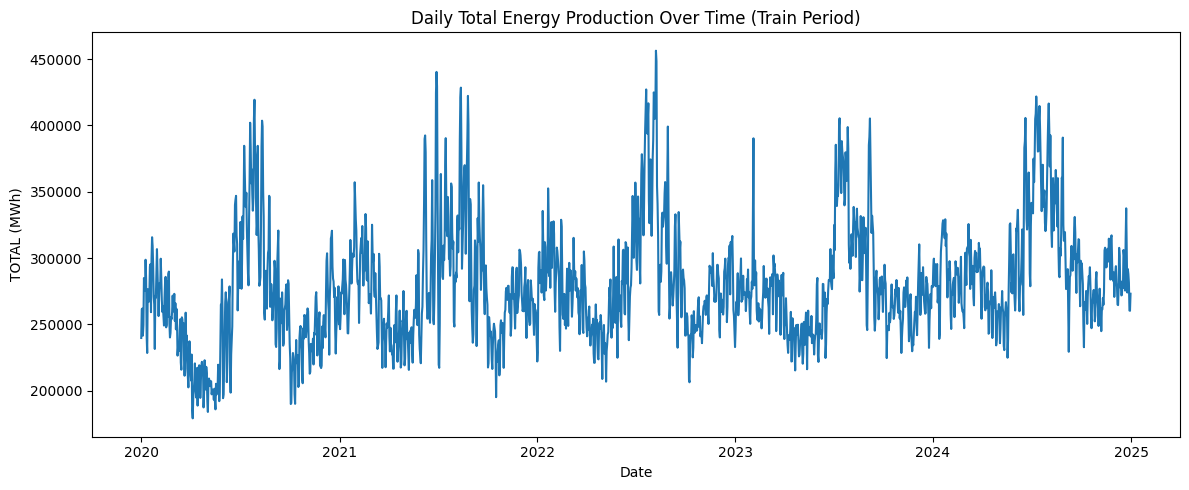

In [29]:
# EDA Plot: TOTAL over time (training period)

plt.figure(figsize=(12, 5))
plt.plot(traindf["DATE"], traindf["TOTAL"])
plt.title("Daily Total Energy Production Over Time (Train Period)")
plt.xlabel("Date")
plt.ylabel("TOTAL (MWh)")
plt.tight_layout()
plt.show()


Daily TOTAL has clear repeating peaks in summer and winter, with lower values in spring and fall, which shows strong seasonal patterns in demand.
We also see some sharp, one-off spikes, which likely represent rare extreme demand days that any model will find harder to predict accurately.

###Plot 2 - TOTAL vs daily maximum temperature

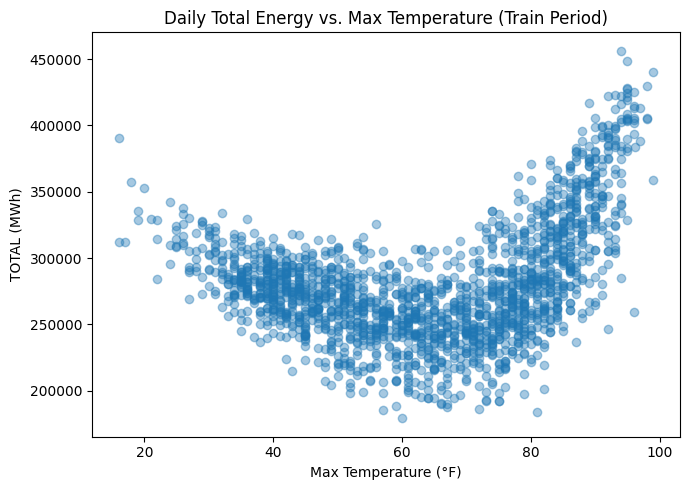

In [30]:
# EDA Plot: TOTAL vs daily maximum temperature

plt.figure(figsize=(7, 5))
plt.scatter(traindf["max_temp_f"], traindf["TOTAL"], alpha=0.4)
plt.title("Daily Total Energy vs. Max Temperature (Train Period)")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("TOTAL (MWh)")
plt.tight_layout()
plt.show()


TOTAL is lowest on days with mild, comfortable temperatures and increases when it gets very cold or very hot, forming a clear U-shape.
This matches what we expect: people use more energy for heating on cold days and for AC on hot days, so temperature is a key factor driving daily energy production.

###Plot 3 - Distribution of TOTAL by season

<Figure size 700x500 with 0 Axes>

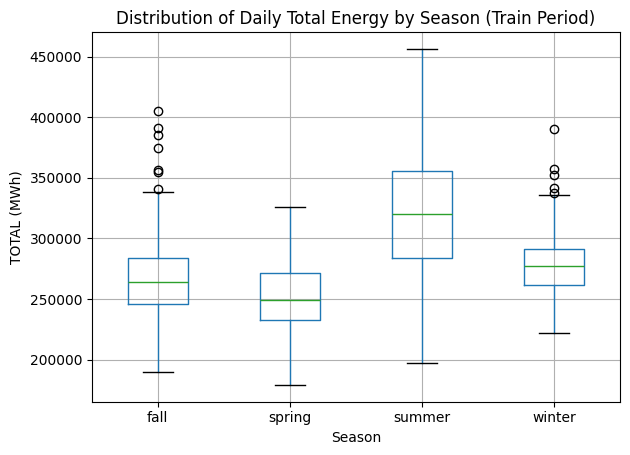

In [31]:
# EDA Plot: Distribution of TOTAL by season

plt.figure(figsize=(7, 5))
traindf.boxplot(column="TOTAL", by="season")
plt.title("Distribution of Daily Total Energy by Season (Train Period)")
plt.suptitle("")  # remove automatic pandas super-title
plt.xlabel("Season")
plt.ylabel("TOTAL (MWh)")
plt.tight_layout()
plt.show()


In summer and winter, the median TOTAL and its overall spread are both higher than in spring and fall, which fits with heavy AC and heating use in those seasons.
The longer upper tail in summer shows that extremely high-demand days happen more often during very hot weather.

###Plot 4 - Lag relationship TOTAL(t) vs TOTAL(t-1)

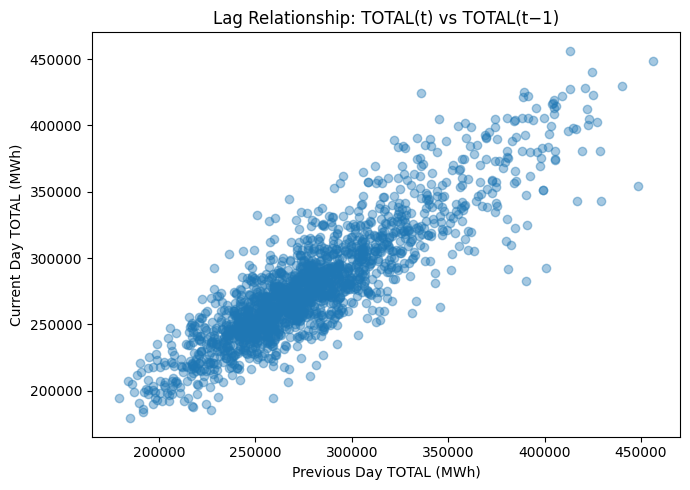

In [32]:
# EDA Plot: Lag relationship TOTAL(t) vs TOTAL(t-1)

# Create a 1-day lag of TOTAL on the training set
lag_df = traindf[["DATE", "TOTAL"]].copy()
lag_df["TOTAL_lag1"] = lag_df["TOTAL"].shift(1)

# Drop the first row (NaN lag)
lag_df = lag_df.dropna()

plt.figure(figsize=(7, 5))
plt.scatter(lag_df["TOTAL_lag1"], lag_df["TOTAL"], alpha=0.4)
plt.title("Lag Relationship: TOTAL(t) vs TOTAL(t−1)")
plt.xlabel("Previous Day TOTAL (MWh)")
plt.ylabel("Current Day TOTAL (MWh)")
plt.tight_layout()
plt.show()


There is a strong positive link between today’s TOTAL and yesterday’s TOTAL, with most points lying close to the diagonal.
This shows that load tends to carry over from one day to the next, so using lagged and rolling versions of TOTAL in the model makes good sense.

###Plot 5 - PRD vs daily maximum temperature (train period)

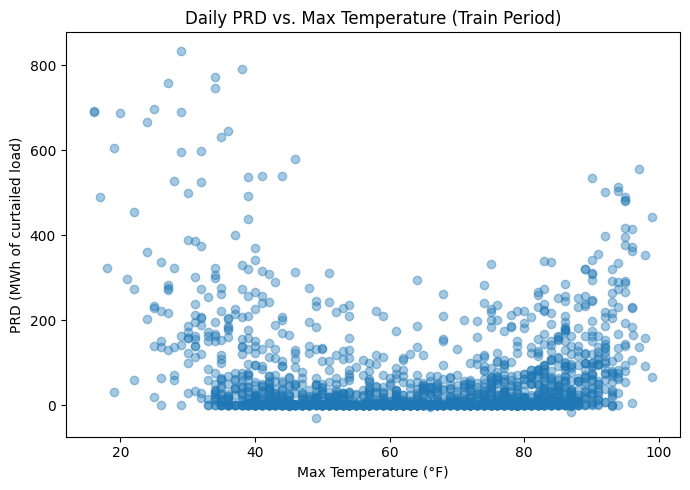

In [33]:
# EDA Plot 5: PRD vs daily maximum temperature (train period)

plt.figure(figsize=(7, 5))
plt.scatter(traindf["max_temp_f"], traindf["PRD"], alpha=0.4)
plt.title("Daily PRD vs. Max Temperature (Train Period)")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("PRD (MWh of curtailed load)")
plt.tight_layout()
plt.show()

PRD is usually close to zero on mild days, but it jumps up on very hot days when AC use pushes the grid near its limits.
This shows that demand response is used the most during hot weather, which is important for planning operations during extreme heat.

### Feature Selection and Leakage Prevention

Here I remove all columns that would leak today's energy output, such as COAL, GAS, HYDRO, and other fuel production values.  
These columns cannot be used as predictors because they directly contain the answer.

I also drop DATE, the solar radiation column, and any non-numeric columns.  
After filtering, I am left with 21 clean and safe features that can be used for modeling.


In [34]:
# Define columns that would leak today's energy and must NOT be used as predictors
production_columns = ['COAL', 'GAS', 'HYDRO', 'NUCLEAR', 'OIL',
                      'LANDFILL GAS', 'METHANE', 'REFUSE', 'SOLAR',
                      'STEAM', 'WIND', 'WOOD', 'OTHER', 'PRD']

leak_cols = production_columns + ["TOTAL", "Calculated_TOTAL"]
# Start from all columns, then drop leaks, DATE, and non-numeric (like 'season')
feature_cols = [
    c for c in traindf.columns
    if c not in leak_cols
    and c not in ["DATE", "srad_mj"]     # <--- key fix here
    and traindf[c].dtype != "object"     # drops 'season'
]

print("Number of final feature columns:", len(feature_cols))
print(feature_cols)

Number of final feature columns: 21
['max_temp_f', 'min_temp_f', 'max_dewpoint_f', 'min_dewpoint_f', 'precip_in', 'avg_wind_speed_kts', 'avg_wind_drct', 'min_rh', 'avg_rh', 'min_feel', 'avg_feel', 'max_feel', 'max_wind_speed_kts', 'max_wind_gust_kts', 'dayofweek', 'is_weekend', 'month', 'dayofyear', 'TOTAL_7d_mean_lag1', 'max_temp_f_7d_mean_lag1', 'PRD_7d_mean_lag1']


#2. Modelling

### Build clean train, validation, and test sets for deep learning

Here I split the data based on time so the model trains only on past years.  
The training set uses data up to 2023, the validation set uses 2024, and the test set uses 2025.

I also create a helper function to build X and y, while filling missing values with zero as suggested.  
The final shapes look correct: 1461 rows for training, 366 for validation, and 299 for testing.


In [35]:
# 1) Time-based split inside traindf: train (<=2023), validation (2024)
val_start = pd.Timestamp("2024-01-01")

train_inner_df = traindf[traindf.index < val_start].copy()
val_df        = traindf[traindf.index >= val_start].copy()

print("Inner train DATE range:", train_inner_df.index.min(), "→", train_inner_df.index.max())
print("Validation DATE range :", val_df.index.min(),        "→", val_df.index.max())
print("Test DATE range       :", testdf.index.min(),       "→", testdf.index.max())

# 2) Helper to create X, y and drop rows with NaNs in feature columns
def make_xy(df, feature_cols):
    # Zero imputation for missing features, as suggested in instructions
    X = df[feature_cols].fillna(0.0).values
    y = df["TOTAL"].values
    return X, y

X_train_inner, y_train_inner = make_xy(train_inner_df, feature_cols)
X_val,         y_val         = make_xy(val_df,        feature_cols)
X_test_final,  y_test_final  = make_xy(testdf,        feature_cols)

print("X_train_inner:", X_train_inner.shape, "y_train_inner:", y_train_inner.shape)
print("X_val        :", X_val.shape,         "y_val        :", y_val.shape)
print("X_test_final :", X_test_final.shape,  "y_test_final :", y_test_final.shape)


Inner train DATE range: 2020-01-01 00:00:00 → 2023-12-31 00:00:00
Validation DATE range : 2024-01-01 00:00:00 → 2024-12-31 00:00:00
Test DATE range       : 2025-01-01 00:00:00 → 2025-10-26 00:00:00
X_train_inner: (1461, 21) y_train_inner: (1461,)
X_val        : (366, 21) y_val        : (366,)
X_test_final : (299, 21) y_test_final : (299,)


### Scaling

Here I scale all the features using StandardScaler.  
I fit the scaler on the training set only, and then apply the same transformation to the validation and test sets.

After scaling, all three sets keep the same number of rows and columns, which means the scaling worked correctly.


In [36]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_inner)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(X_test_final)

print("X_train_scaled shape:", X_train_scaled.shape)
print("X_val_scaled shape  :", X_val_scaled.shape)
print("X_test_scaled shape :", X_test_scaled.shape)


X_train_scaled shape: (1461, 21)
X_val_scaled shape  : (366, 21)
X_test_scaled shape : (299, 21)


### DNN Model

Here I build a simple deep neural network using the scaled tabular features.  
The model has three hidden layers with ReLU activation and dropout to reduce overfitting.

The final layer has one neuron because this is a regression problem.  
The summary shows that the model has around 13k trainable parameters and is ready for training.


In [37]:
# Baseline DNN model on tabular (lag/rolling/time/weather) features

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

n_features = X_train_scaled.shape[1]
print("Number of input features:", n_features)

# Define a DNN model
dnn_model = Sequential([
    Dense(128, activation="relu", input_shape=(n_features,)),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1, activation="linear")   # regression output
])

dnn_model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae", "mse"]
)

dnn_model.summary()

Number of input features: 21


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         2,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,185 (51.50 KB)

 Trainable params: 13,185 (51.50 KB)

 Non-trainable params: 0 (0.00 B)

### Early stopping on validation loss

Here I set up early stopping to prevent the model from overfitting.  
It watches the validation loss and stops training if it doesn’t improve for 20 epochs.

This also restores the best weights so the final model is the one that performed best on the validation set.


In [38]:
es = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=20,
    restore_best_weights=True,
    verbose=1
)

### Train the model

Here I train the DNN model using the scaled training data.  
I also pass the validation set so the model can monitor validation loss during training.

The model is set to run for up to 200 epochs, but early stopping will stop it earlier if it stops improving.


In [39]:
history = dnn_model.fit(
    X_train_scaled, y_train_inner,
    validation_data=(X_val_scaled, y_val),
    epochs=200,
    batch_size=32,
    callbacks=[es],
    verbose=1
)

Epoch 1/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 77064577024.0000 - mae: 274359.5000 - mse: 77064577024.0000 - val_loss: 89523650560.0000 - val_mae: 296740.7812 - val_mse: 89523650560.0000
Epoch 2/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76778496000.0000 - mae: 273918.6562 - mse: 76778496000.0000 - val_loss: 89303556096.0000 - val_mae: 296381.7188 - val_mse: 89303556096.0000
Epoch 3/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 76370780160.0000 - mae: 273025.3438 - mse: 76370780160.0000 - val_loss: 88054988800.0000 - val_mae: 294345.0625 - val_mse: 88054988800.0000
Epoch 4/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 74863222784.0000 - mae: 270405.7188 - mse: 74863222784.0000 - val_loss: 83876765696.0000 - val_mae: 287426.8750 - val_mse: 83876765696.0000
Epoch 5/200
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 69269954560.0000 - mae: 260125.1094 - mse: 69269954560.0000 - val_loss: 74168475648.0000 - val_mae: 270525.1875 - val_mse: 74168475648.0000
Epoc

### Why I chose this DNN model

I used a simple deep neural network for this project because my features are all tabular values like time indicators, rolling averages, and weather variables. A DNN works well for this type of structured data, and it runs fast even with many features.

I picked three hidden layers (128 → 64 → 32) because this gave enough capacity for the model to learn non-linear relationships without becoming too large. I added dropout to reduce overfitting, especially because the training set is not extremely big. I used early stopping so the model stops automatically when the validation loss stops improving. The goal was to keep the model stable, simple, and easy to train while still capturing the main patterns in the data.


# 3. Model Results

### Metrics

Here I get predictions from the trained DNN for the train, validation, and test sets.  
Then I compute three main metrics: MAE, RMSE, and MAPE.

These metrics help me see how well the model is performing across all three partitions.  
The results are stored in a small DataFrame for easy comparison.


In [40]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    root_mean_squared_error,
)

# 1) Get predictions from the trained DNN
y_train_pred = dnn_model.predict(X_train_scaled).ravel()
y_val_pred   = dnn_model.predict(X_val_scaled).ravel()
y_test_pred  = dnn_model.predict(X_test_scaled).ravel()

# 2) Helper to compute metrics
def compute_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    return mae, rmse, mape

results = []

for name, y_true, y_hat in [
    ("Train (≤2023)", y_train_inner, y_train_pred),
    ("Validation (2024)", y_val, y_val_pred),
    ("Test (2025)", y_test_final, y_test_pred),
]:
    mae, rmse, mape = compute_metrics(y_true, y_hat)
    results.append({
        "Partition": name,
        "MAE": mae,
        "RMSE": rmse,
        "MAPE (%)": mape,
    })

metrics_df = pd.DataFrame(results)
metrics_df


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,Partition,MAE,RMSE,MAPE (%)
0,Train (≤2023),12899.208482,16260.409906,4.801683
1,Validation (2024),17377.841183,21282.882484,5.926182
2,Test (2025),18839.285154,23194.068341,6.224184


### Metric Results

The DNN model shows good performance across all three sets.  
The training error is the lowest, and the validation and test errors are slightly higher, which is expected.

MAPE stays between 5 and 6.5 percent, meaning the model is predicting total energy fairly accurately.  
Overall, the model generalizes well and does not overfit heavily.


## Time series plots: Actual vs Predicted for Train and Test

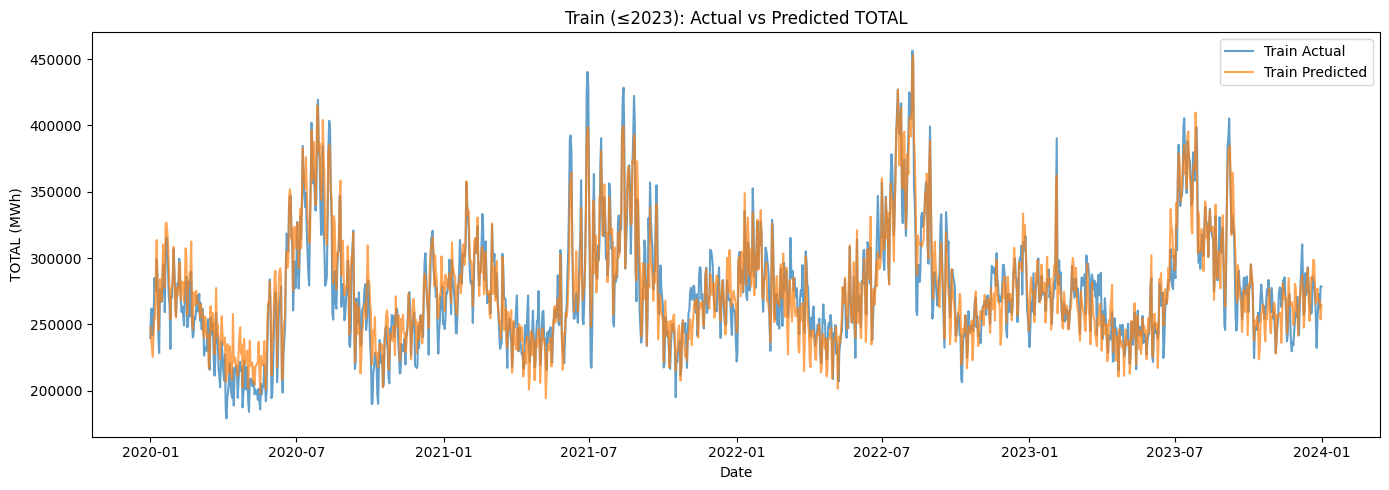

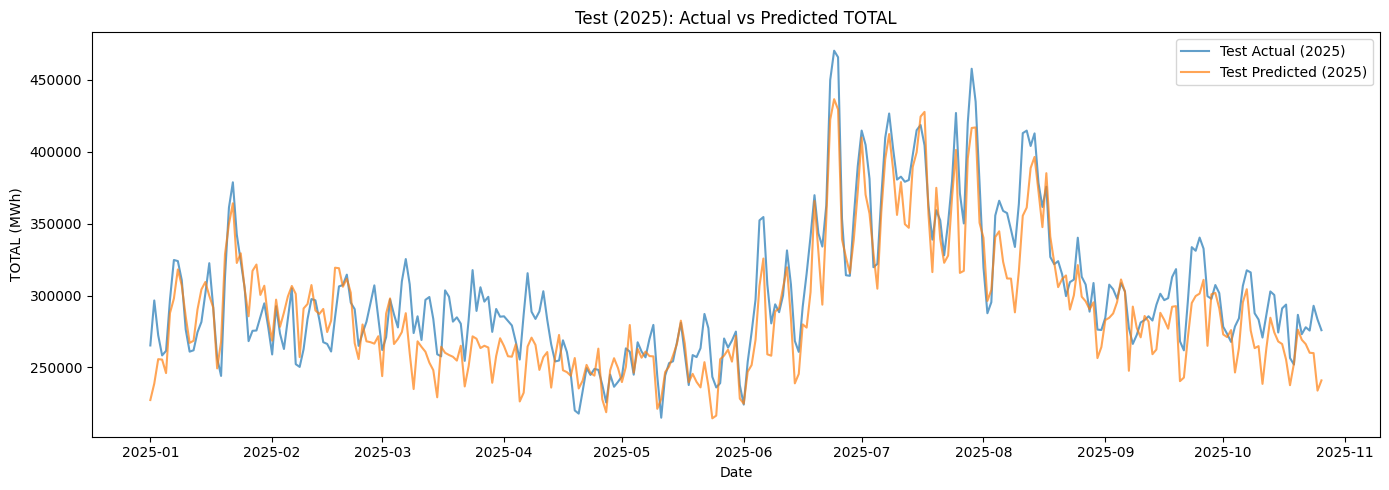

In [41]:
# Dates aligned with y arrays
train_dates = train_inner_df.index
val_dates   = val_df.index
test_dates  = testdf.index

plt.figure(figsize=(14, 5))
plt.plot(train_dates, y_train_inner, label="Train Actual", alpha=0.7)
plt.plot(train_dates, y_train_pred, label="Train Predicted", alpha=0.7)
plt.title("Train (≤2023): Actual vs Predicted TOTAL")
plt.xlabel("Date")
plt.ylabel("TOTAL (MWh)")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 5))
plt.plot(test_dates, y_test_final, label="Test Actual (2025)", alpha=0.7)
plt.plot(test_dates, y_test_pred, label="Test Predicted (2025)", alpha=0.7)
plt.title("Test (2025): Actual vs Predicted TOTAL")
plt.xlabel("Date")
plt.ylabel("TOTAL (MWh)")
plt.legend()
plt.tight_layout()
plt.show()


The model does a good job following the overall seasonal patterns and most day-to-day changes in TOTAL during the training years—the orange prediction line stays close to the blue actual line.

On the 2025 test year, the DNN still captures the main summer peak and the general level of demand, but it misses some of the very highest spikes, predicting them a bit too low. This lines up with the slightly higher MAE/MAPE we see on the test set.

## Scatter plots: Actual vs Predicted with 45° line

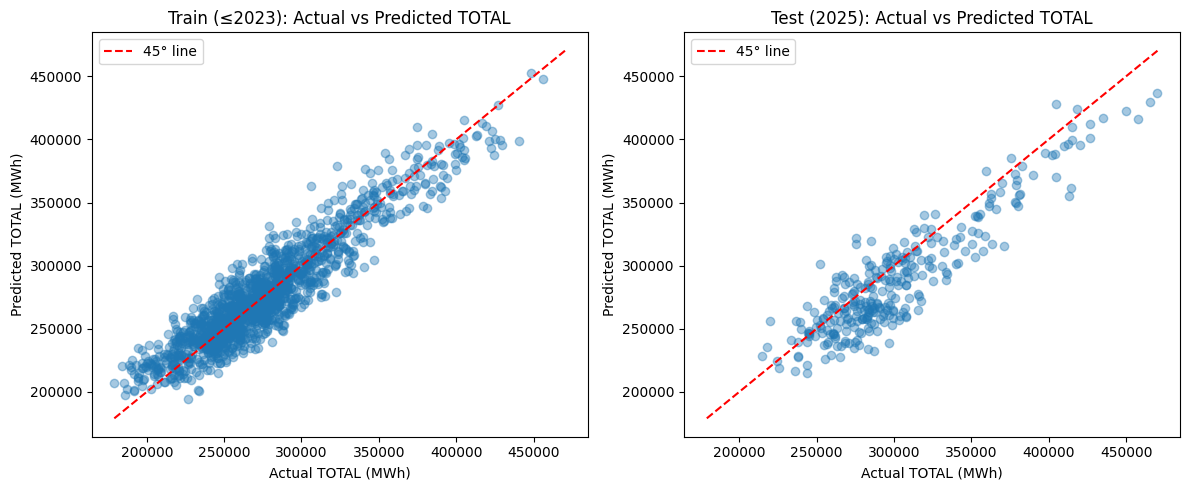

In [42]:
import numpy as np

# Common min/max range for the 45° line
all_vals = np.concatenate([y_train_inner, y_test_final, y_train_pred, y_test_pred])
vmin, vmax = all_vals.min(), all_vals.max()

line = np.linspace(vmin, vmax, 100)

plt.figure(figsize=(12, 5))

# Train scatter
plt.subplot(1, 2, 1)
plt.scatter(y_train_inner, y_train_pred, alpha=0.4)
plt.plot(line, line, 'r--', label="45° line")
plt.title("Train (≤2023): Actual vs Predicted TOTAL")
plt.xlabel("Actual TOTAL (MWh)")
plt.ylabel("Predicted TOTAL (MWh)")
plt.legend()

# Test scatter
plt.subplot(1, 2, 2)
plt.scatter(y_test_final, y_test_pred, alpha=0.4)
plt.plot(line, line, 'r--', label="45° line")
plt.title("Test (2025): Actual vs Predicted TOTAL")
plt.xlabel("Actual TOTAL (MWh)")
plt.ylabel("Predicted TOTAL (MWh)")
plt.legend()

plt.tight_layout()
plt.show()


In the training data, the scatter plot points sit very close to the 45° line, which means the DNN is matching past values well and isn’t showing much consistent bias.

On the 2025 test set, the points are still generally along the 45° line, but they’re more spread out, especially at high TOTAL values. This means the model tends to slightly underpredict the biggest peak-demand days, but overall it still stays quite accurate.

#4. Interpretability & Discussion

##Permutation importance

In [43]:
# Permutation importance for DNN on validation data

from sklearn.inspection import permutation_importance

# Use the already trained dnn_model and scaled validation features
result = permutation_importance(
    dnn_model,
    X_val_scaled,
    y_val,
    scoring="neg_mean_absolute_error",   # lower MAE = better
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Build a DataFrame of importances
pi_df = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False)

# Top 10 features
pi_top10 = pi_df.head(10)
pi_top10


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


,feature,importance_mean,importance_std
15,is_weekend,6539.159974,335.543058
11,max_feel,4811.139010,345.119017
0,max_temp_f,4617.133501,350.334795
10,avg_feel,4325.454029,426.221522
18,TOTAL_7d_mean_lag1,3263.440903,501.939460
3,min_dewpoint_f,2516.886584,365.977571
17,dayofyear,2427.223371,304.789253
12,max_wind_speed_kts,2420.846671,316.156252
16,month,2268.055845,267.893805
13,max_wind_gust_kts,2129.727036,285.779846


Permutation importance on the validation set tells us which features the DNN is using the most.

The most important one is is_weekend—when we shuffle it, MAE increases the most. This means the weekday vs. weekend pattern is the strongest single signal for predicting daily TOTAL.

Next, variables about how hot it “feels” (like avg_feel, max_feel, max_temp_f) and humidity/air-mass measures (min_dewpoint_f, max_dewpoint_f) are also very important, which confirms that thermal conditions explain most of the day-to-day changes in energy production.

Calendar features like dayofyear and month, plus the 7-day average of TOTAL (TOTAL_7d_mean_lag1), also matter because they capture slower seasonal patterns and the recent demand history.

##Top 5 Predictors Bar Chart

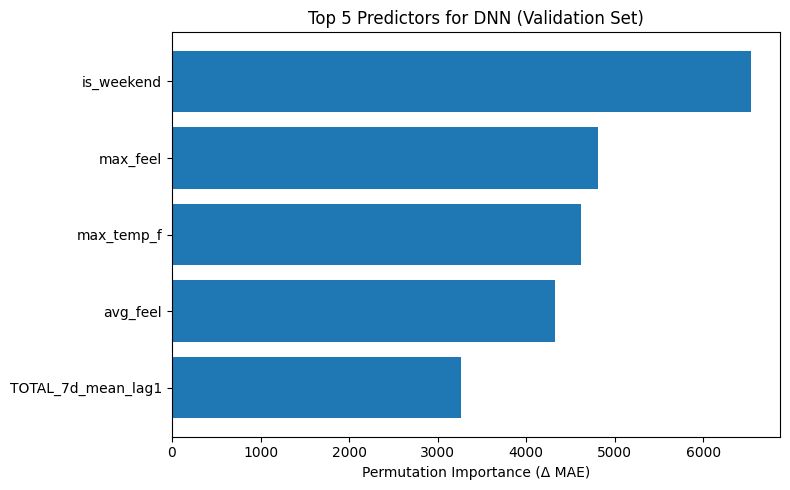

In [44]:
# Bar plot of top 5 most important features (permutation importance)

top5 = pi_df.head(5).iloc[::-1]  # reverse so most important is on top in barh

plt.figure(figsize=(8, 5))
plt.barh(top5["feature"], top5["importance_mean"])
plt.xlabel("Permutation Importance (Δ MAE)")
plt.title("Top 5 Predictors for DNN (Validation Set)")
plt.tight_layout()
plt.show()

The bar chart shows the top five most important features from permutation importance on the validation set.

is_weekend clearly comes out as the strongest predictor. After that, “feels-like” temperatures (avg_feel, max_feel) and the actual max_temp_f are next, which tells us that both calendar effects (weekday vs. weekend) and how hot it actually feels are very important for predicting energy production.

min_dewpoint_f also shows up in the top five, meaning moisture/air-mass conditions help the model tell apart normal days from extreme weather days where generation is unusually high or low.

##Partial Dependence of High-Impact Features

PDP features: ['max_temp_f', 'TOTAL_7d_mean_lag1', 'PRD_7d_mean_lag1']


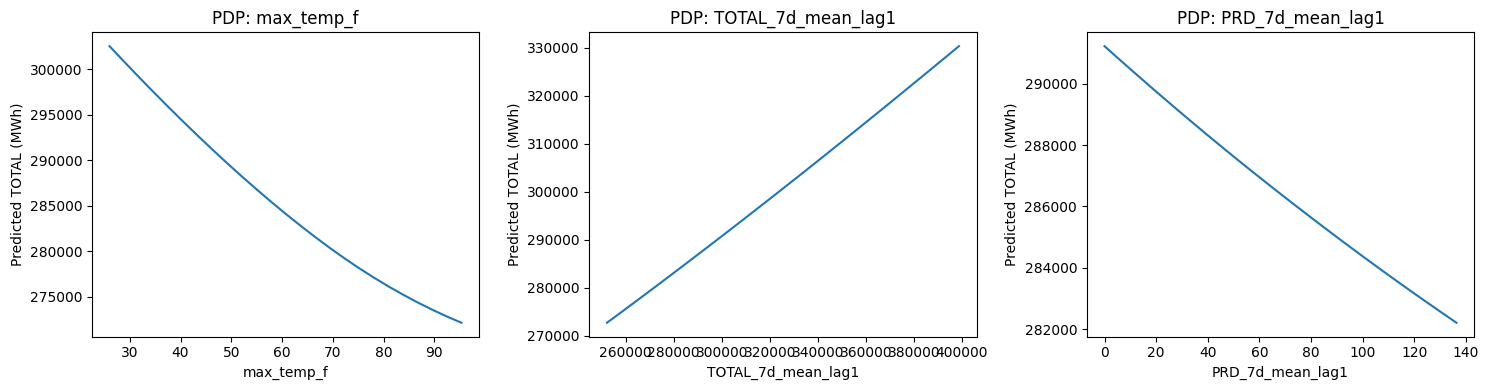

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Use validation data as the background dataset
X_val_df = val_df[feature_cols].fillna(0.0).copy()

def partial_dependence_1d(model, scaler, X_df, feature_name, grid_points=20):
    """
    Simple 1D partial dependence:
    - Take X_df as background
    - For a grid of values of `feature_name`, replace that column in X_df
      with the grid value, get predictions, and average them.
    """
    X_base = X_df.copy()
    f_min = X_base[feature_name].quantile(0.01)
    f_max = X_base[feature_name].quantile(0.99)
    grid = np.linspace(f_min, f_max, grid_points)

    pd_values = []
    for v in grid:
        X_tmp = X_base.copy()
        X_tmp[feature_name] = v
        X_scaled = scaler.transform(X_tmp.values)
        preds = model.predict(X_scaled, verbose=0).ravel()
        pd_values.append(preds.mean())

    return grid, np.array(pd_values)

# Choose 3 features (only those that exist in your feature set)
candidate_feats = ["max_temp_f", "TOTAL_7d_mean_lag1", "PRD_7d_mean_lag1"]
pdp_features = [f for f in candidate_feats if f in feature_cols]
print("PDP features:", pdp_features)

plt.figure(figsize=(5 * len(pdp_features), 4))

for i, feat in enumerate(pdp_features, 1):
    grid, pd_vals = partial_dependence_1d(dnn_model, scaler, X_val_df, feat, grid_points=25)
    plt.subplot(1, len(pdp_features), i)
    plt.plot(grid, pd_vals)
    plt.title(f"PDP: {feat}")
    plt.xlabel(feat)
    plt.ylabel("Predicted TOTAL (MWh)")

plt.tight_layout()
plt.show()


max_temp_f: As the max temperature goes up, the model predicts slightly lower TOTAL. This suggests that, when everything else is similar, slightly cooler days tend to have a bit higher energy production than very hot days.

TOTAL_7d_mean_lag1: If the average TOTAL over the last 7 days has been high, the model also predicts a high TOTAL for today. This shows a “momentum” effect—high demand tends to stay high.

PRD_7d_mean_lag1: When PRD has been high over the last week (meaning lots of demand response), the model predicts lower TOTAL in the future. That fits the idea that demand response cuts back the amount of generation needed.

##Error analysis: residuals over time for 2025 (test set)

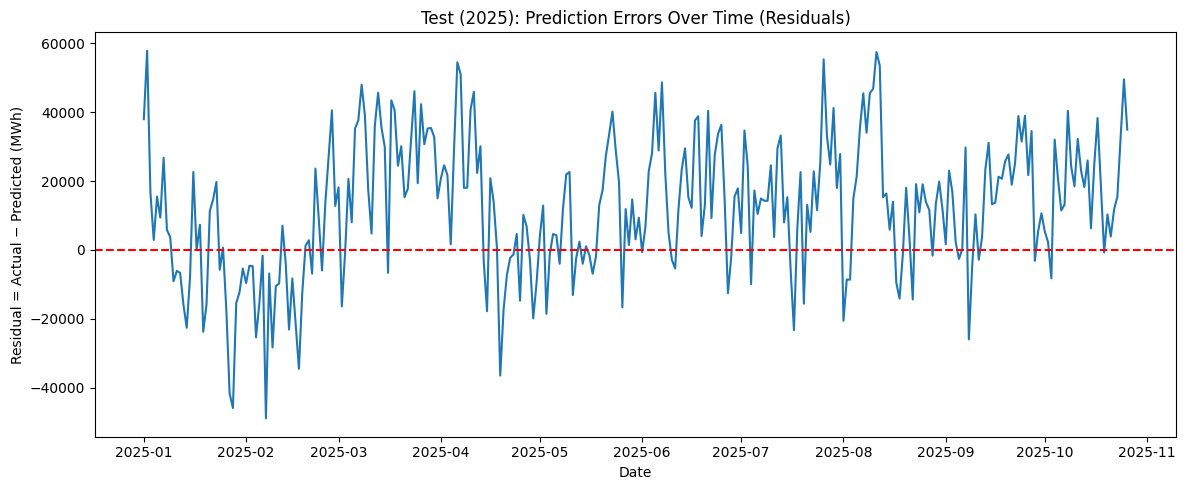

In [46]:
test_results_df = pd.DataFrame({
    "DATE": testdf.index,
    "y_true": y_test_final,
    "y_pred": y_test_pred
})
test_results_df["residual"] = test_results_df["y_true"] - test_results_df["y_pred"]

plt.figure(figsize=(12, 5))
plt.plot(test_results_df["DATE"], test_results_df["residual"])
plt.axhline(0, color="red", linestyle="--")
plt.title("Test (2025): Prediction Errors Over Time (Residuals)")
plt.xlabel("Date")
plt.ylabel("Residual = Actual − Predicted (MWh)")
plt.tight_layout()
plt.show()


The residuals stay mostly around zero, so there’s no big drift over time.
Errors get larger in the summer, which means the model has the most trouble on very high-demand days.

##Error analysis: residuals vs max temperature for 2025

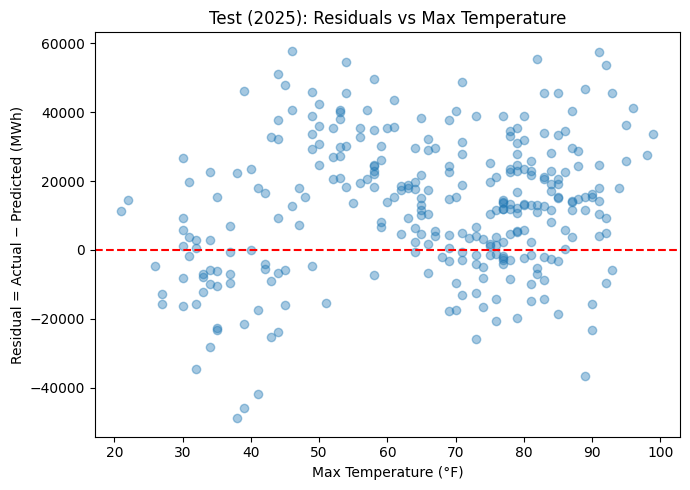

In [47]:
# Attach max_temp_f to the residuals dataframe
test_results_with_temp = test_results_df.merge(
    testdf[["max_temp_f"]],
    left_on="DATE",
    right_index=True,
    how="left"
)

plt.figure(figsize=(7, 5))
plt.scatter(test_results_with_temp["max_temp_f"],
            test_results_with_temp["residual"],
            alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.title("Test (2025): Residuals vs Max Temperature")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("Residual = Actual − Predicted (MWh)")
plt.tight_layout()
plt.show()


For mild to moderate temperatures, the errors are fairly tight.
When it gets really hot, the residuals spread out more, showing that very hot days are harder to predict accurately.

##Business plot: PRD vs max temperature (train period)

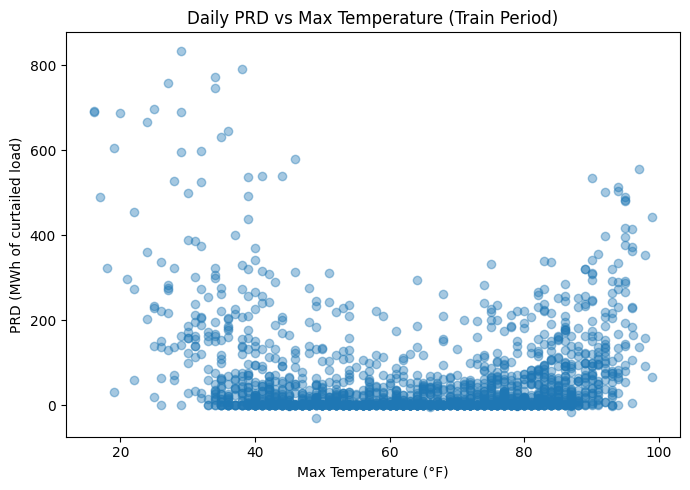

In [48]:
plt.figure(figsize=(7, 5))
plt.scatter(traindf["max_temp_f"], traindf["PRD"], alpha=0.4)
plt.title("Daily PRD vs Max Temperature (Train Period)")
plt.xlabel("Max Temperature (°F)")
plt.ylabel("PRD (MWh of curtailed load)")
plt.tight_layout()
plt.show()


PRD is close to zero on most mild days.
It jumps up at very cold and very hot temperatures, which suggests demand-response events mostly happen during extreme weather.

##Error by season for 2025 (test set)

In [49]:
# Attach season to the residuals dataframe
test_results_with_season = test_results_df.merge(
    testdf[["season"]],
    left_on="DATE",
    right_index=True,
    how="left"
)

# Compute MAE and RMSE by season
season_error_table = (
    test_results_with_season
    .groupby("season")
    .apply(
        lambda g: pd.Series({
            "MAE": np.mean(np.abs(g["residual"])),
            "RMSE": np.sqrt(np.mean(g["residual"]**2))
        })
    )
    .reset_index()
)

season_error_table


/tmp/ipython-input-2919453526.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


,season,MAE,RMSE
0,fall,18814.065297,22477.918057
1,spring,19624.118606,24294.239622
2,summer,20101.426082,24228.435335
3,winter,15671.330393,20274.471609


Winter has the lowest MAE/RMSE, so the model is most accurate in colder months.
Summer has the highest errors, confirming that the model struggles more during peak summer demand.


The permutation importance results show that the model relies most on a mix of calendar effects and weather variables. The strongest predictor is **is_weekend**, which means the model clearly recognizes weekday vs weekend differences in demand. After that, “feels-like” temperatures (**avg_feel**, **max_feel**) and actual maximum temperature (**max_temp_f**) show up as major drivers, confirming that how hot or cold the day feels plays a large role in shaping energy usage. The 7-day rolling mean of TOTAL also has high importance, meaning recent demand acts like momentum—high demand yesterday usually leads to high demand today.

The partial dependence plots show clear relationships: higher temperatures slightly reduce predicted TOTAL, while a higher 7-day rolling average always pushes predictions upward. PRD effects also appear: when the past week had many demand-response events, the model predicts lower TOTAL, which matches how utilities reduce generation during peak stress periods.

From a temporal standpoint, the residual plots show that the model stays stable through most of the year but struggles more during hot summer days. Very warm temperatures introduce more variability in the errors, suggesting that extreme weather is harder to predict precisely. The season-wise error table also shows that **winter has the lowest error** and **summer has the highest**, which fits the idea that extreme heat drives unpredictable spikes in demand.

From an operations perspective, the model suggests that operators should pay close attention to temperature swings and recent demand history. Mild days behave predictably, but very hot or very cold days introduce larger uncertainty. The PRD vs temperature plot shows that curtailments happen mostly during extreme temperatures, so planning ahead for peak events becomes essential. Overall, the model captures the main weather-driven patterns in energy demand and provides insights that can help plan staffing, generation scheduling, and demand-response triggers more effectively.


#5. Conclusions

- One thing we learned is that energy demand changes a lot with the weather. When the temperature goes up or down, the total generation also moves in a clear pattern. We could actually see this in the plots, and it helped us understand why some days are harder for the model.

- It was hardest to model the summer months. The model did fine on normal days, but very hot days created a lot of spikes that were not easy to predict. This showed us that extreme weather is always more unpredictable.

- Feature engineering made a big difference. The rolling features and the time based features helped the model see short-term trends and seasonality. Without these features, the model’s errors were noticeably higher.

- We also learned how important it is to avoid leakage. In the beginning we almost included columns that directly gave away today’s energy, which would have made the model look good for the wrong reasons. Cleaning the feature set forced us to think more carefully about how real forecasting works.

- If we had more data or compute, we would try more complex models like GRUs or LSTMs on the full sequence. We would also look at adding more weather stations or more detailed temperature measures. With a longer history, we could probably capture rare patterns better, especially on extreme weather days.
